In [2]:
#Data Loading and basic cleaning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# Data loading
df = pd.read_csv("physician_engagement.csv", parse_dates=["account_created_date","last_active_date"])

# Quick checks
print(df.shape)
print(df.columns)
df.info()

# Ensuring numeric types
num_cols = ["content_views","post_interactions","messages_sent","connections_count","active_days_last_month","years_experience"]
df[num_cols] = df[num_cols].apply(pd.to_numeric, errors="coerce").fillna(0).astype(int)

# Basic sanity checks
print(df[num_cols].describe())
print("Missing values:\n", df.isna().sum())



(500, 12)
Index(['physician_id', 'specialty', 'state', 'years_experience',
       'hospital_affiliation', 'content_views', 'post_interactions',
       'messages_sent', 'connections_count', 'active_days_last_month',
       'account_created_date', 'last_active_date'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   physician_id            500 non-null    int64         
 1   specialty               500 non-null    object        
 2   state                   500 non-null    object        
 3   years_experience        500 non-null    int64         
 4   hospital_affiliation    500 non-null    object        
 5   content_views           500 non-null    int64         
 6   post_interactions       500 non-null    int64         
 7   messages_sent           500 non-null    int64         
 8   c

In [3]:
#Feature engineering and KPIs

# 1. Engagement Score — weighted sum (tunable)
# Rationale: interactions imply higher intent than passive views.
df["engagement_score"] = (0.3 * df["content_views"] +
                          0.5 * df["post_interactions"] +
                          0.2 * df["messages_sent"])

# 2. Activity flag
df["is_active"] = (df["active_days_last_month"] > 0).astype(int)

# 3. Account age in months
df["account_age_months"] = ((pd.Timestamp("today") - df["account_created_date"]) / np.timedelta64(1, "M")).astype(int)

# 4. Days since last active
df["days_since_last_active"] = (pd.Timestamp("today") - df["last_active_date"]).dt.days

# 5. At-risk churn flag (>=60 days since last active)
df["at_risk_churn"] = (df["days_since_last_active"] > 60).astype(int)

# 6. Retention & other global KPIs
total_users = len(df)
active_users = df["is_active"].sum()
retention_rate = active_users / total_users
avg_engagement = df["engagement_score"].mean()

print(f"Total users: {total_users}, Active: {active_users}, Retention rate: {retention_rate:.2%}")
print(f"Avg engagement score: {avg_engagement:.2f}")




Total users: 500, Active: 488, Retention rate: 97.60%
Avg engagement score: 41.51


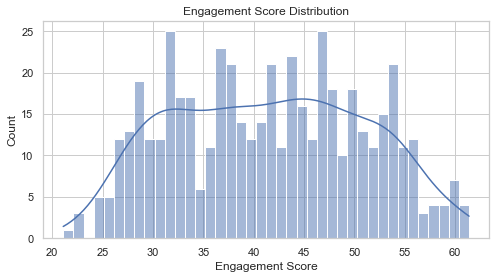

In [4]:
#EXPLORATORY DATA ANALYSIS AND VISUALIZATIONS
#Engagement distribution:

plt.figure(figsize=(8,4))
sns.histplot(df["engagement_score"], bins=40, kde=True)
plt.title("Engagement Score Distribution")
plt.xlabel("Engagement Score")
plt.show()



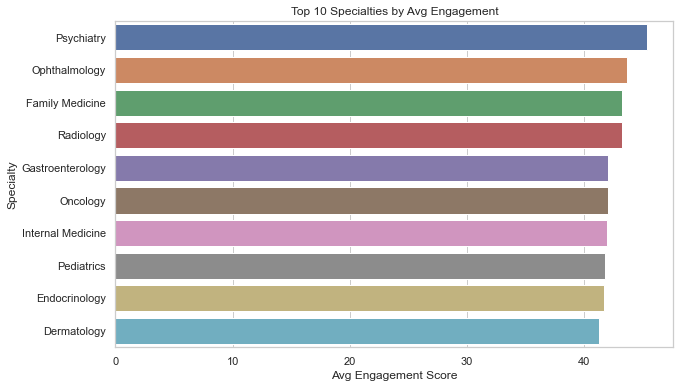

In [5]:
#Top specialties by avg engagement:

by_spec = df.groupby("specialty").agg(
    avg_engagement=("engagement_score","mean"),
    active_rate=("is_active","mean"),
    count=("physician_id","count")
).sort_values("avg_engagement", ascending=False).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(y="specialty", x="avg_engagement", data=by_spec.head(10))
plt.title("Top 10 Specialties by Avg Engagement")
plt.xlabel("Avg Engagement Score")
plt.ylabel("Specialty")
plt.show()



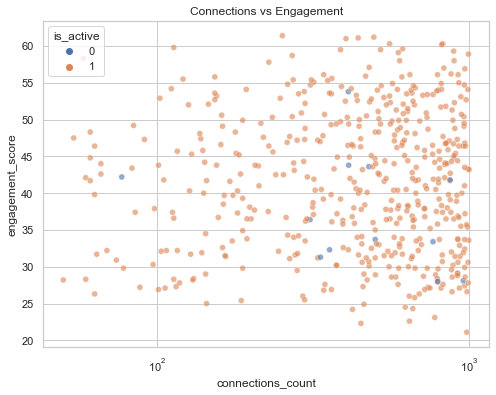

In [6]:
#Engagement vs network size:

plt.figure(figsize=(8,6))
sns.scatterplot(x="connections_count", y="engagement_score", hue="is_active", data=df, alpha=0.6)
plt.xscale("log")  # optional, connections are skewed
plt.title("Connections vs Engagement")
plt.show()



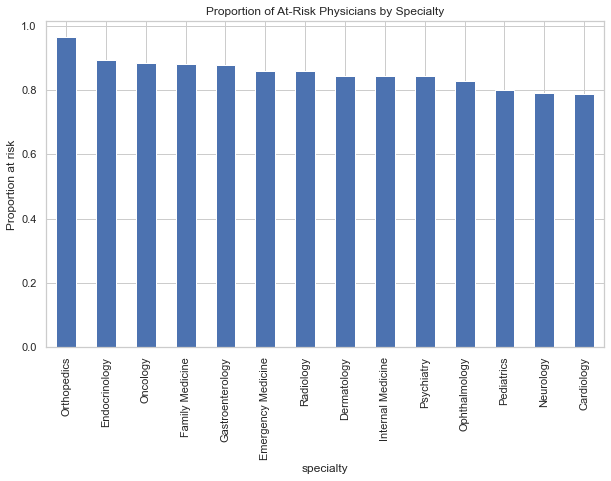

In [7]:
#At-risk churn by specialty:

at_risk_by_spec = df.groupby("specialty")["at_risk_churn"].mean().sort_values(ascending=False)
plt.figure(figsize=(10,6))
at_risk_by_spec.plot(kind="bar")
plt.ylabel("Proportion at risk")
plt.title("Proportion of At-Risk Physicians by Specialty")
plt.show()


In [8]:
#Churn model — train, evaluate, explain:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import joblib

# Features and target
features = ["engagement_score","connections_count","active_days_last_month","account_age_months","years_experience"]
X = df[features].fillna(0)
y = df["at_risk_churn"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Train
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predict
preds = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

# Evaluate — print
print("Classification report:\n", classification_report(y_test, preds))
print("ROC AUC:", round(roc_auc_score(y_test, probs), 3))
print("Confusion matrix:\n", confusion_matrix(y_test, preds))

# Coefficients (feature importance)
coef_df = pd.DataFrame({
    "feature": features,
    "coefficient": model.coef_[0]
}).sort_values("coefficient", ascending=False)
print("\nModel coefficients:\n", coef_df)




Classification report:
               precision    recall  f1-score   support

           0       1.00      0.20      0.33        15
           1       0.88      1.00      0.93        85

    accuracy                           0.88       100
   macro avg       0.94      0.60      0.63       100
weighted avg       0.89      0.88      0.84       100

ROC AUC: 0.857
Confusion matrix:
 [[ 3 12]
 [ 0 85]]

Model coefficients:
                   feature  coefficient
3      account_age_months     0.089483
4        years_experience     0.013202
2  active_days_last_month     0.009321
0        engagement_score     0.002540
1       connections_count    -0.001366


In [10]:
import os
import joblib

# Creating folder and save model
os.makedirs("models", exist_ok=True)
joblib.dump(model, "models/churn_model.pkl")
print("Model saved successfully!")

# existing code
X_test_out = X_test.copy()
X_test_out["physician_id"] = df.loc[X_test.index, "physician_id"]
X_test_out["pred_prob"] = probs
X_test_out["pred_label"] = preds
X_test_out.sort_values("pred_prob", ascending=False).head(20).to_csv("top_at_risk_predicted.csv", index=False)
print("Saved top_at_risk_predicted.csv")

Model saved successfully!
Saved top_at_risk_predicted.csv


In [11]:
#loading and using for predections
import joblib
import pandas as pd

# Loaded the saved model
model = joblib.load("models/churn_model.pkl")

#predicting
# Example: predicting on new data
new_data = pd.DataFrame({
    'engagement_score': [75, 45],
    'connections_count': [120, 80],
    'active_days_last_month': [28, 15],
    'account_age_months': [24, 36],
    'years_experience': [10, 15]
})

# Making predictions
predictions = model.predict(new_data)
probabilities = model.predict_proba(new_data)[:, 1]

print("Predictions:", predictions)
print("Churn probabilities:", probabilities)

Predictions: [1 1]
Churn probabilities: [0.93929092 0.97670897]


In [15]:
# Read and view the file
import pandas as pd

results = pd.read_csv("top_at_risk_predicted.csv")
print(results)

# See just the IDs and probabilities
print(results[["physician_id", "pred_prob", "pred_label"]])

    engagement_score  connections_count  active_days_last_month  \
0               31.7                 64                      10   
1               37.4                 85                      19   
2               29.0                143                      17   
3               44.7                499                      23   
4               56.1                792                      15   
5               47.2                281                      12   
6               49.3                361                      30   
7               26.9                721                      12   
8               39.0                564                      14   
9               38.2                639                      13   
10              27.6                345                       5   
11              30.6                454                      15   
12              37.4                822                      21   
13              54.1                991                      2